# Hi :)

----

# Import libraries

In [1]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
from filterpy.kalman import ExtendedKalmanFilter as EKF
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

# Initialization

In [2]:
# Physical parameters
m= 0.1    # pendulum mass (kg)
M= 5.0    # cart mass (kg)
g= 9.81   # gravity (m/s^2)
l= 0.72   # pendulum length (m)
dt= 0.001 # sampling time (s) = 1ms

# Continuous-time dynamics
def pendulum_dynamics(x, u):
    x1, x2, x3, x4= x

    dx1= x2

    num2= u * np.cos(x1) - (M + m) * g * np.sin(x1) + m * l * np.cos(x1) * np.sin(x1) * x2**2
    den2= m * l * np.cos(x1)**2 - (M + m) * l
    dx2= num2 / den2

    dx3= x4

    num4= u + m * l * np.sin(x1) * x2**2 - m * g * np.cos(x1) * np.sin(x1)
    den4= M + m - m * np.cos(x1)**2
    dx4= num4 / den4

    return np.array([dx1, dx2, dx3, dx4])

# Discretization

In [3]:
# Discretization using Euler integration
def discrete_step(x, u, dt):
    dx= pendulum_dynamics(x, u)
    return x + dt * dx

In [4]:
# Initial state and zero input
x0= np.array([0.0, 0.0, 0.0, 0.0])
u= 0

In [5]:
# Simulate for 100 steps
x= x0
states= [x0]
for _ in range(100):
    x= discrete_step(x, u, dt)
    states.append(x)

states= np.array(states)

Visualization

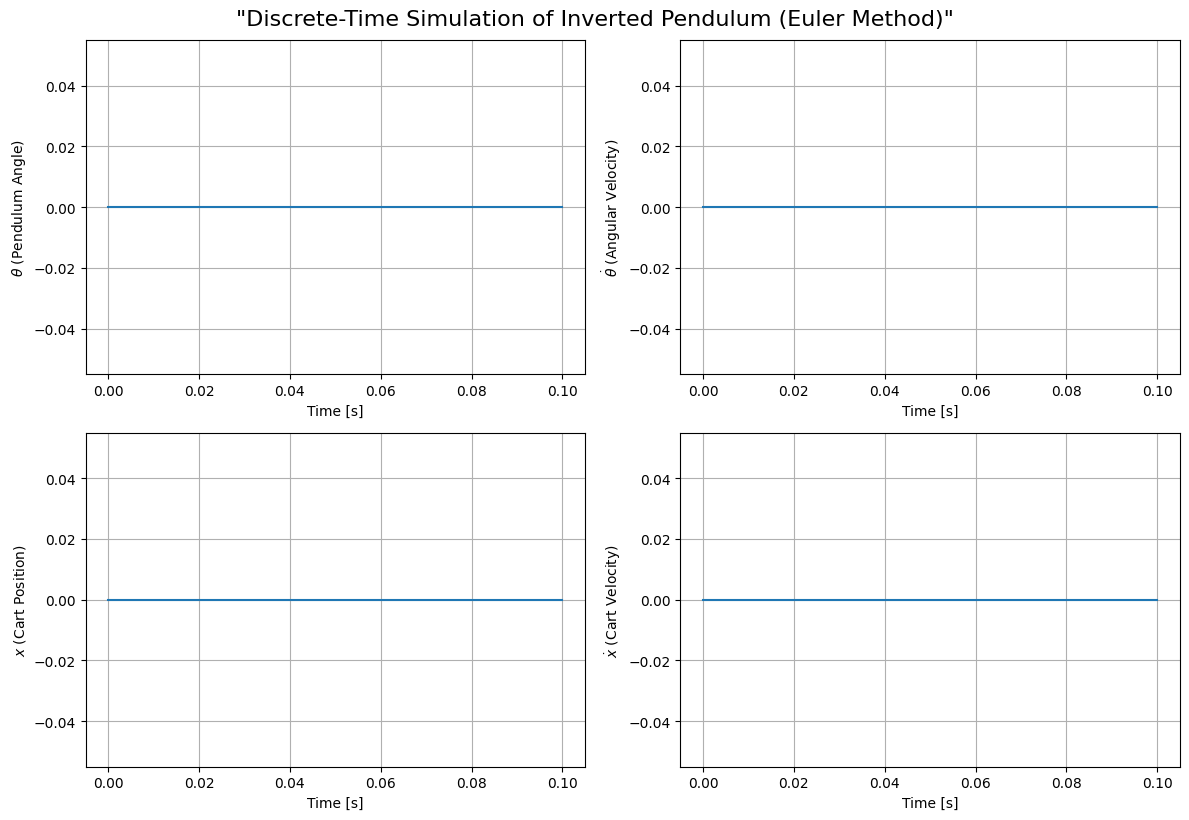

In [6]:
# Time vector
time= np.arange(states.shape[0]) * dt

# Plotting
plt.figure(figsize=(12, 8))

labels= [r'$\theta$ (Pendulum Angle)', 
          r'$\dot{\theta}$ (Angular Velocity)', 
          r'$x$ (Cart Position)', 
          r'$\dot{x}$ (Cart Velocity)']

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(time, states[ : , i])
    plt.xlabel('Time [s]')
    plt.ylabel(labels[i])
    plt.grid(True)

plt.tight_layout()
plt.suptitle('"Discrete-Time Simulation of Inverted Pendulum (Euler Method)"', fontsize= 16, y= 1.02)
plt.show()

# Making the noisy dataset

Initialization

In [7]:
# Random seed for reproducibility
np.random.seed(48)

# Constants
T= 10.0  # total simulation time in seconds
dt= 0.001
N= int(T / dt) + 1  # number of time steps

# Initial state from uniform distribution
x0= np.random.uniform(-0.1, 0.1, size= 4)

# Process and measurement noise covariance
Q= np.array([
    [15.0, 0, 0, 0],
    [0, 9.6, 0, 0],
    [0, 0, 10.0, 0],
    [0, 0, 0, 17.0]
])
R= np.array([
    [19.2, 0],
    [0, 16.8]
])

# Prameters setup for simulation
u= 0.0

# Warning!

You can skip cells below till the next seperate line if you already have the "pendulum_noisy_data.xlsx" file.

----

Simulation

In [8]:
# Simulate with process and measurement noise
states= np.zeros((N, 4))
measurements= np.zeros((N, 2))
x= x0.copy()

for t in range(N):
    # Save state
    states[t]= x
    # Generate measurement (y1 = x1, y2 = x3)
    y= np.array([x[0], x[2]]) + np.random.multivariate_normal(np.zeros(2), R)
    measurements[t]= y
    # Apply dynamics + process noise
    x= discrete_step(x, u, dt) + np.random.multivariate_normal(np.zeros(4), Q)

# Simulation
df_states= pd.DataFrame(states, columns=['x1', 'x2', 'x3', 'x4'])
df_measurements= pd.DataFrame(measurements, columns= ['y1', 'y2'])
df= pd.concat([df_states, df_measurements], axis= 1)
df.head()

,x1,x2,x3,x4,y1,y2
0,-0.096502,0.078315,-0.043028,-0.040205,-2.892411,4.308191
1,4.139569,2.247808,-6.604332,-0.689180,11.477467,-8.232918
2,0.269992,-3.971172,-8.373199,8.891932,-1.333998,-13.522470
3,2.571565,1.751338,-3.434971,17.306869,-2.288290,-9.727630
4,-0.948620,0.314196,-2.214273,24.142718,-0.488177,-3.967612


In [9]:
# Saving to Excel
df.to_excel('pendulum_noisy_data.xlsx', index= False)

Visualization

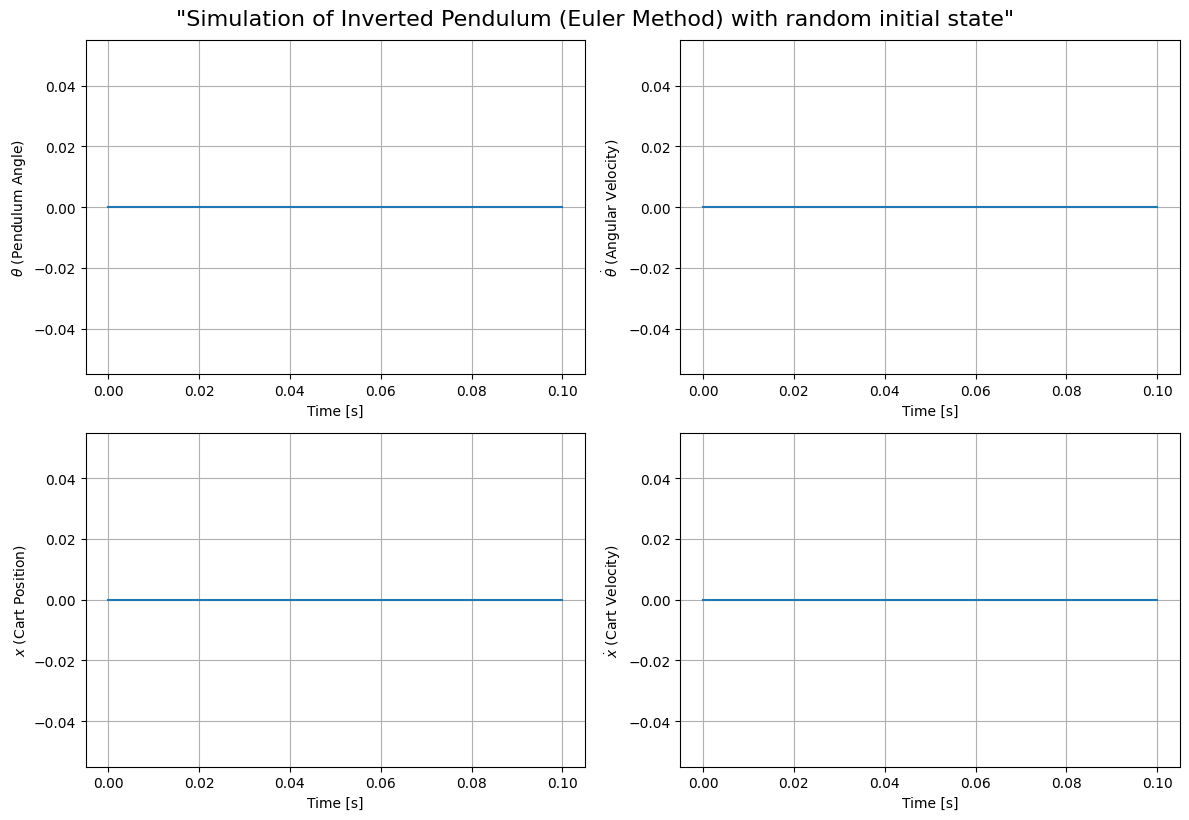

In [8]:
# Time vector
time= np.arange(states.shape[0]) * dt

# Plotting
plt.figure(figsize=(12, 8))

labels= [r'$\theta$ (Pendulum Angle)', 
          r'$\dot{\theta}$ (Angular Velocity)', 
          r'$x$ (Cart Position)', 
          r'$\dot{x}$ (Cart Velocity)']

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(time, states[ : , i])
    plt.xlabel('Time [s]')
    plt.ylabel(labels[i])
    plt.grid(True)

plt.tight_layout()
plt.suptitle('"Simulation of Inverted Pendulum (Euler Method) with random initial state"', fontsize= 16, y= 1.02)
plt.show()

----

# EKF & UKF & PF

Loading the data

In [8]:
# Load data
data= pd.read_excel('pendulum_noisy_data.xlsx')

# Extract true states and measurements
X_true= data[['x1', 'x2', 'x3', 'x4']].values
Y_meas= data[['y1', 'y2']].values

In [9]:
# Constants
dt= 0.001
steps= X_true.shape[0]

# EKF

Manual implementation

Initialization

In [10]:
# --- System dynamics (as before) ---
def f(x, u= 0):
    return discrete_step(x, u, dt)

# --- Measurement model ---
def h(x):
    return np.array([x[0], x[2]])

# --- Jacobians using finite difference ---
def jacobian_f(x, eps= 1e-5):
    n= len(x)
    F= np.zeros((n, n))
    fx= f(x)
    for i in range(n):
        dx= np.zeros(n)
        dx[i] = eps
        F[:, i]= (f(x + dx) - fx) / eps
    return F

def jacobian_h(x):
    H= np.zeros((2, 4))
    H[0, 0]= 1
    H[1, 2]= 1
    return H

# Initial state guess and covariance
x_est= np.zeros(4)
P= np.eye(4) * 1.0

# Noise covariances
Q_ekf= Q
R_ekf= R

EKF loop

In [11]:
# Store results
X_ekf= np.zeros_like(X_true)

for k in range(steps):
    # Prediction
    F_k= jacobian_f(x_est)
    x_pred= f(x_est)
    P_pred= F_k @ P @ F_k.T + Q_ekf

    # Update
    H_k= jacobian_h(x_pred)
    y_pred= h(x_pred)
    y= Y_meas[k]
    S= H_k @ P_pred @ H_k.T + R_ekf
    K= P_pred @ H_k.T @ inv(S)

    x_est= x_pred + K @ (y - y_pred)
    P= (np.eye(4) - K @ H_k) @ P_pred

    # Store estimate
    X_ekf[k]= x_est

RMSE

In [12]:
rmse_ekf= np.sqrt(np.mean((X_true - X_ekf)**2, axis= 0))
print("EKF RMSE for each state:", rmse_ekf)

EKF RMSE for each state: [  3.35942272 115.22321828   3.00195536 137.09247471]


Visualization

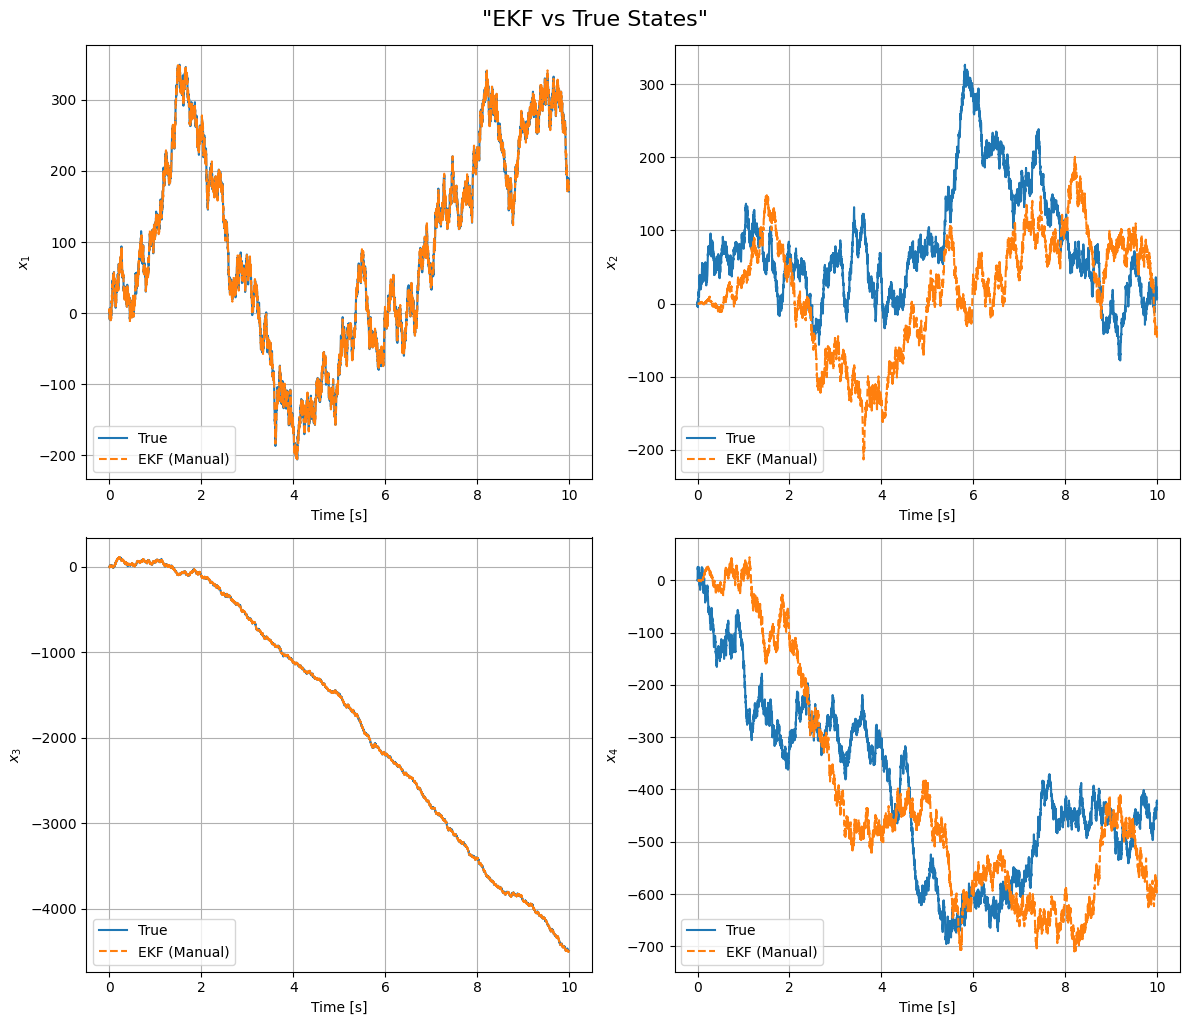

In [13]:
time= np.arange(steps) * dt
labels= [r'$x_1$', r'$x_2$', r'$x_3$', r'$x_4$']

plt.figure(figsize= (12, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(time, X_true[:, i], label= 'True', linewidth= 1.5)
    plt.plot(time, X_ekf[:, i], label= 'EKF (Manual)', linestyle= '--')
    plt.xlabel('Time [s]')
    plt.ylabel(labels[i])
    plt.grid(True)
    plt.legend(loc= 3)

plt.tight_layout()
plt.suptitle('"EKF vs True States"', fontsize= 16, y= 1.02)
plt.show()

EKF implementation using filterpy

Initialization

In [14]:
# --- Load Data ---
true_states= X_true
measurements= Y_meas
N= true_states.shape[0]

In [15]:
# --- Define State Transition Function ---
def fx(x, dt):
    return f(x, u)

# --- Define Measurement Function ---
def hx(x):
    return h(x)

# --- Jacobian of fx (F matrix) ---
def jacobian_F(x, dt):
    x1, x2, x3, x4= x
    # Partial derivatives manually derived:
    d_dx1= 1
    d_dx2= 0
    d_dx3= 1
    d_dx4= 0

    # More complicated terms
    denom2= (m * l * np.cos(x1)**2 - (M + m) * l)
    denom4 = (M + m - m * np.cos(x1)**2)

    dfdx1= ((M + m) * g * np.cos(x1) - m * l * (np.sin(x1)**2 - np.cos(x1)**2) * x2**2) / denom2 \
             - ((m * l * np.sin(2 * x1)) * ((0 * np.cos(x1) - (M + m) * g * np.sin(x1) + m * l * np.cos(x1) * np.sin(x1) * x2**2))) / denom2**2

    dfdx2= (2 * m * l * np.cos(x1) * np.sin(x1) * x2) / denom2

    dgdx1= (2 * m * g * np.sin(x1) * np.sin(x1) - m * g * np.cos(x1) * np.cos(x1) - m * l * x2**2 * np.cos(x1) * np.cos(x1) - m * l * x2**2 * np.sin(x1) * np.sin(x1)) / denom4 \
             - ((-2 * m * np.sin(x1) * np.cos(x1)) * (m * l * np.sin(x1) * x2**2 - m * g * np.cos(x1) * np.sin(x1))) / denom4**2

    dgdx2= (2 * m * l * np.sin(x1) * x2) / denom4

    F= np.eye(4)
    F[0,1]= dt
    F[1,0]= dfdx1 * dt
    F[1,1]= dfdx2 * dt
    F[2,3]= dt
    F[3,0]= dgdx1 * dt
    F[3,1]= dgdx2 * dt

    return F

# --- Jacobian of hx (H matrix) ---
def jacobian_H(x):
    # Measurement model y = [x1, x3]
    H= np.zeros((2, 4))
    H[0,0]= 1
    H[1,2]= 1
    return H

# --- EKF Setup ---
ekf= EKF(dim_x= 4, dim_z= 2)

ekf.x= np.random.uniform(-0.1, 0.1, size= 4)  # Initial guess

ekf.P= np.eye(4) * 0.1

ekf.Q= Q

ekf.R= R

EKF loop using filterpy

In [16]:
# --- Run EKF on all measurements ---
estimated_states= []
for z in measurements:
    F= jacobian_F(ekf.x, dt)
    ekf.F= F
    ekf.predict()
    ekf.update(z, HJacobian= lambda x: jacobian_H(x), Hx= hx)
    estimated_states.append(ekf.x.copy())


estimated_states= np.array(estimated_states)

RMSE

In [17]:
rmse_ekf_filterpy= np.sqrt(np.mean((true_states - estimated_states)**2, axis= 0))
print("EKF using filterpy RMSE for each state:", rmse_ekf_filterpy)

EKF using filterpy RMSE for each state: [  3.35928358 112.31836472   3.00199005 135.61819559]


Visualization

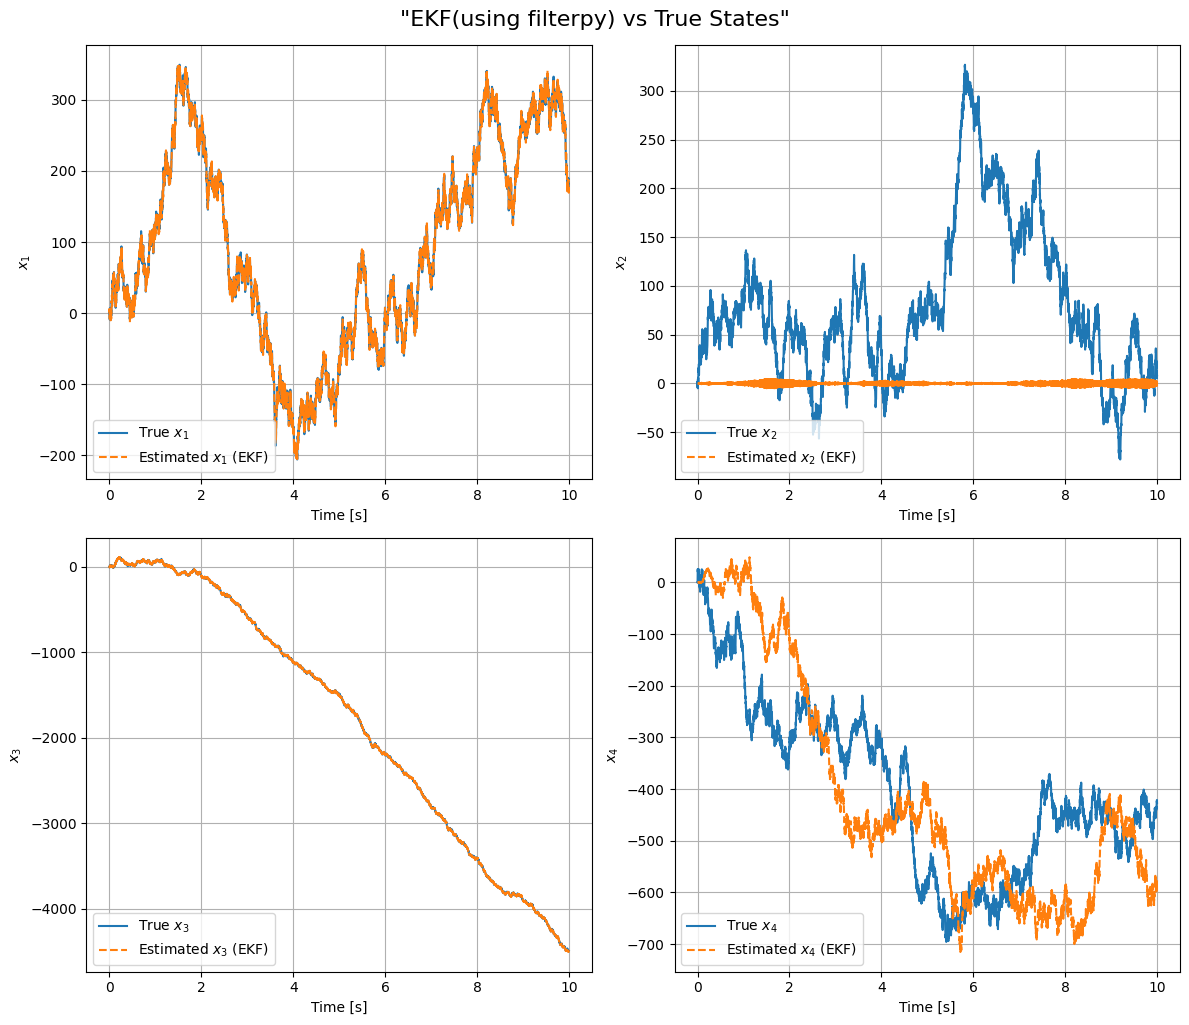

In [18]:
time= np.linspace(0, (N - 1) * dt, N)
state_labels= [r'$x_1$', r'$x_2$', r'$x_3$', r'$x_4$']

plt.figure(figsize= (12, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(time, true_states[:, i], label= f'True {state_labels[i]}', linewidth= 1.5)
    plt.plot(time, estimated_states[:, i], label= f'Estimated {state_labels[i]} (EKF)', linestyle= '--')
    plt.xlabel('Time [s]')
    plt.ylabel(state_labels[i])
    plt.grid(True)
    plt.legend(loc= 3)

plt.tight_layout()
plt.suptitle('"EKF(using filterpy) vs True States"', fontsize= 16, y= 1.02)
plt.show()

# UKF

UKF manually implementation

Initialization

In [19]:
# --- Load Data ---(same as EKF)
true_states= X_true
measurements= Y_meas
N= true_states.shape[0]

In [20]:
# UKF parameters
alpha= 1
kappa= 0
beta= 2

# State transition
def fx(x, dt):
    return f(x, u)

# Measurement function
def hx(x):
    return h(x)

# Sigma point generation
def sigma_points(x, P, alpha, kappa):
    n= len(x)
    lambda_= alpha**2 * (n + kappa) - n
    sigma_pts= np.zeros((2 * n + 1, n))

    try:
        U= np.linalg.cholesky((n + lambda_) * P)
    except np.linalg.LinAlgError:
        U= np.linalg.cholesky((n + lambda_) * (P + 1e-6 * np.eye(n)))

    sigma_pts[0]= x
    for i in range(n):
        sigma_pts[i + 1]= x + U[i]
        sigma_pts[i + 1 + n]= x - U[i]
    return sigma_pts, lambda_

# Weights
def compute_weights(n, lambda_, alpha, beta):
    Wm= np.full(2 * n + 1, 1 / (2 * (n + lambda_)))
    Wc= np.full(2 * n + 1, 1 / (2 * (n + lambda_)))
    Wm[0]= lambda_ / (n + lambda_)
    Wc[0]= lambda_ / (n + lambda_) + (1 - alpha**2 + beta)
    return Wm, Wc

# Initialize
n= 4  # state dimension
m_dim= 2  # measurement dimension

x= np.random.uniform(-0.1, 0.1, size= n)
P= np.eye(n) * 0.1
# Q and R same as before

UKF loop

In [21]:
estimated_states= []

# UKF Loop
for z in measurements:
    # 1. Sigma Points
    chi, lambda_= sigma_points(x, P, alpha, kappa)
    Wm, Wc= compute_weights(n, lambda_, alpha, beta)

    # 2. Predict Sigma Points
    chi_pred= np.array([fx(sp, dt) for sp in chi])

    # 3. Predict Mean and Covariance
    x_pred= np.sum(Wm[:, None] * chi_pred, axis= 0)
    P_pred= Q.copy()
    for i in range(2*n+1):
        diff= chi_pred[i] - x_pred
        P_pred += Wc[i] * np.outer(diff, diff)

    # 4. Predict Measurements
    Z_sigma= np.array([hx(sp) for sp in chi_pred])
    z_pred= np.sum(Wm[:, None] * Z_sigma, axis= 0)
    Pz= R.copy()
    for i in range(2 * n + 1):
        diff= Z_sigma[i] - z_pred
        Pz += Wc[i] * np.outer(diff, diff)

    # 5. Cross Covariance
    Pxz= np.zeros((n, m_dim))
    for i in range(2 * n + 1):
        Pxz += Wc[i] * np.outer(chi_pred[i] - x_pred, Z_sigma[i] - z_pred)

    # 6. Kalman Gain
    K= Pxz @ np.linalg.inv(Pz)

    # 7. Update
    x= x_pred + K @ (z - z_pred)
    P= P_pred - K @ Pz @ K.T

    estimated_states.append(x.copy())

estimated_states= np.array(estimated_states)

RMSE

In [22]:
rmse_ukf= np.sqrt(np.mean((true_states - estimated_states)**2, axis= 0))
print("UKF RMSE for each state:", rmse_ukf)

UKF RMSE for each state: [  3.36023994 114.36215606   3.03782439 133.67032785]


Visualization

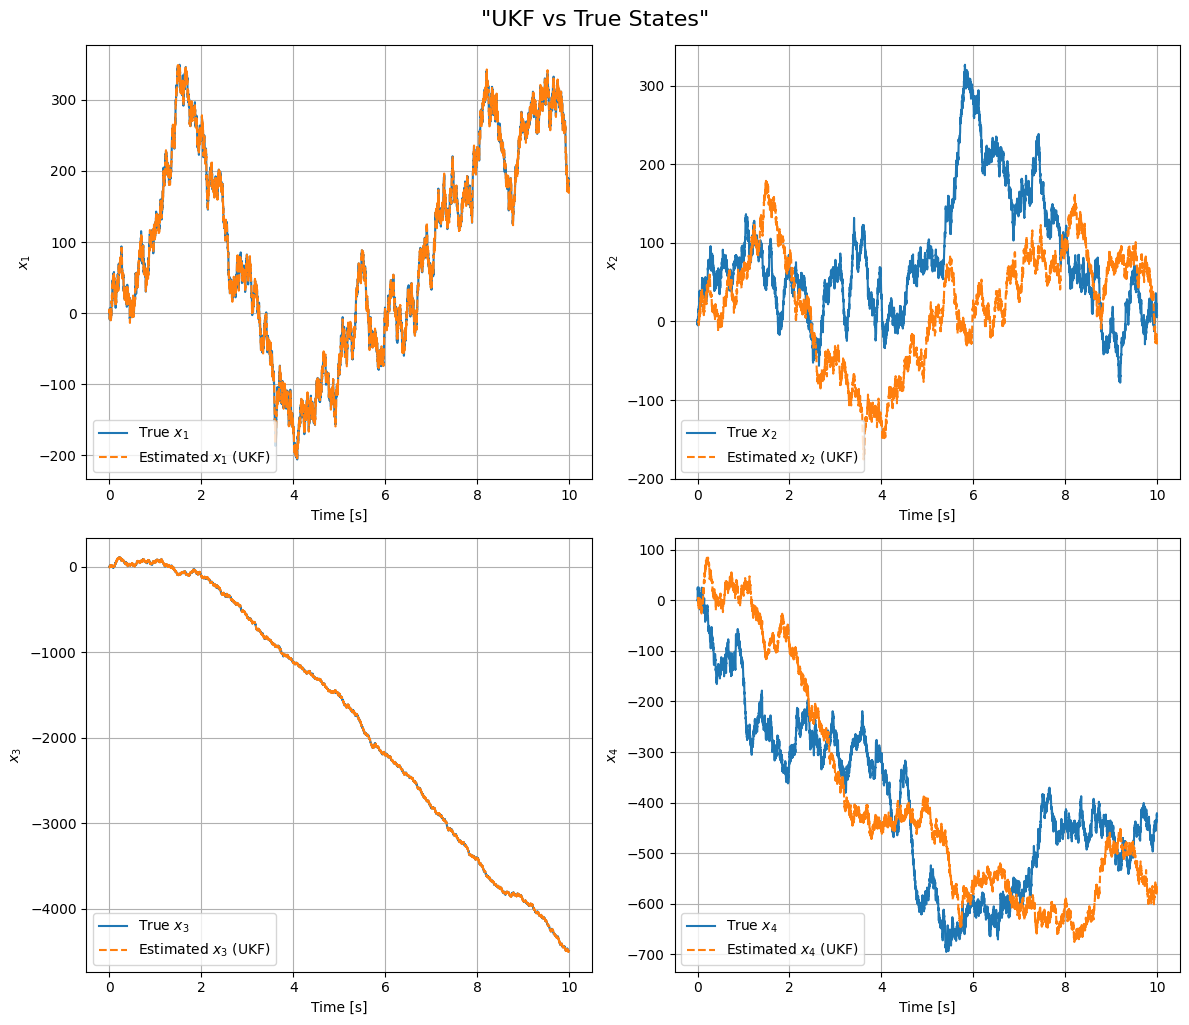

In [23]:
time= np.linspace(0, (N - 1) * dt, N)
state_labels= [r'$x_1$', r'$x_2$', r'$x_3$', r'$x_4$']

plt.figure(figsize= (12, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(time, true_states[:, i], label= f'True {state_labels[i]}', linewidth= 1.5)
    plt.plot(time, estimated_states[:, i], label= f'Estimated {state_labels[i]} (UKF)', linestyle= '--')
    plt.xlabel('Time [s]')
    plt.ylabel(state_labels[i])
    plt.grid(True)
    plt.legend(loc= 3)

plt.tight_layout()
plt.suptitle('"UKF vs True States"', fontsize= 16, y= 1.02)
plt.show()

UKF implementation using filterpy

Initialization

In [24]:
# --- Load Data ---(same as before)
true_states= X_true
measurements= Y_meas
N= true_states.shape[0]

In [25]:
# State transition
def fx(x, dt):
    return f(x, u)

# Measurement function
def hx(x):
    return h(x)

# --- UKF Setup ---
points= MerweScaledSigmaPoints(n= 4, alpha= 0.1, beta= 2., kappa= 0)

ukf= UKF(dim_x= 4, dim_z= 2, fx= fx, hx= hx, dt= dt, points= points)

# Initial guess
ukf.x= np.random.uniform(-0.1, 0.1, size= 4)

# Covariances
ukf.P= np.eye(4) * 0.1  # initial estimation covariance

ukf.Q= Q

ukf.R= R

UKF loop using filterpy

In [26]:
# --- Run UKF on all measurements ---
estimated_states= []

for z in measurements:
    ukf.predict()
    ukf.update(z)
    estimated_states.append(ukf.x.copy())

estimated_states= np.array(estimated_states)

RMSE

In [27]:
rmse_ukf_filterpy= np.sqrt(np.mean((true_states - estimated_states)**2, axis= 0))
print("UKF using filterpy RMSE for each state:", rmse_ukf_filterpy)

UKF using filterpy RMSE for each state: [  3.35981811 118.51868855   3.00102779 143.16531913]


Visualization

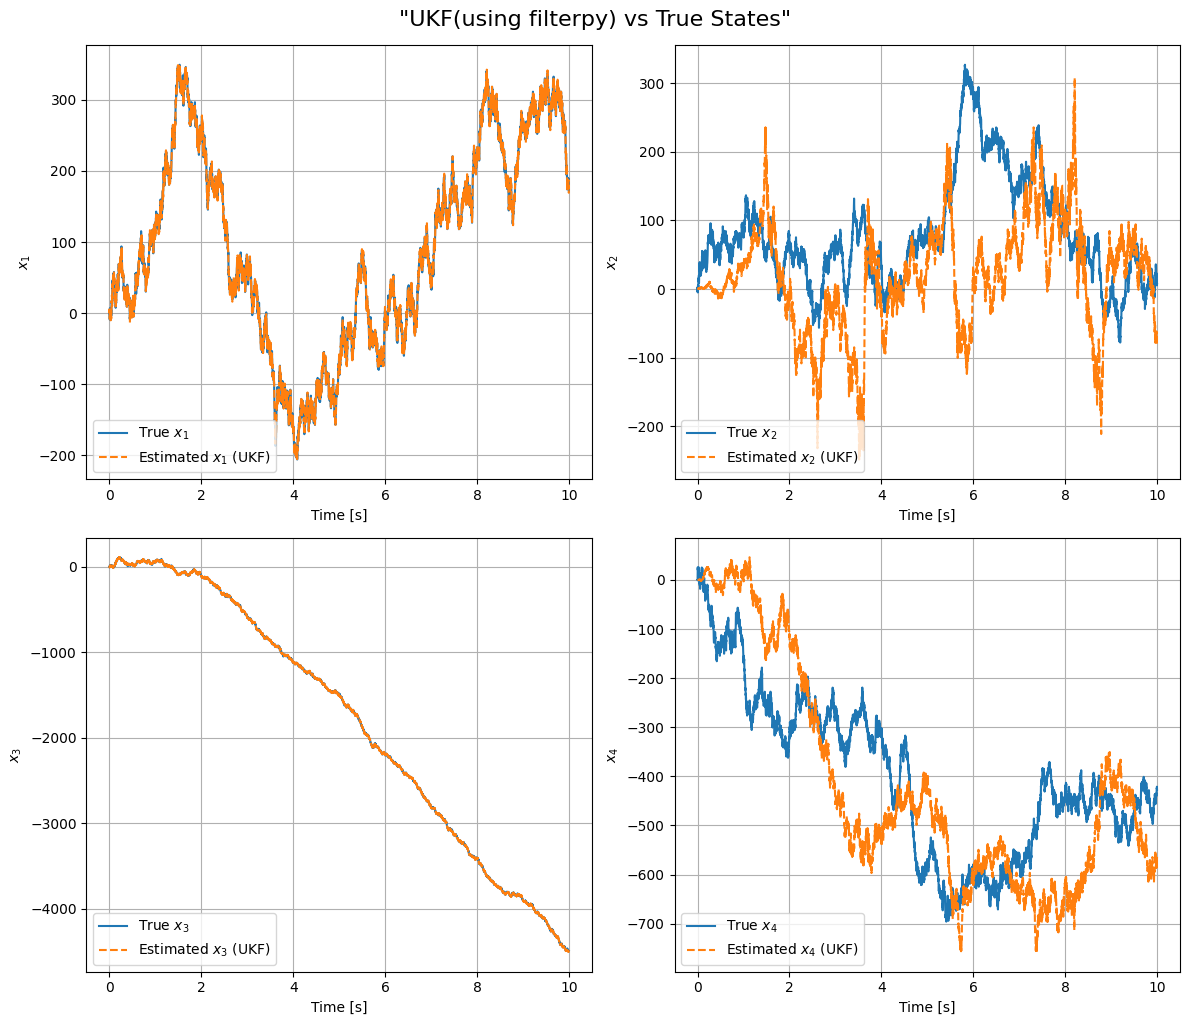

In [28]:
time= np.linspace(0, (N - 1) * dt, N)
state_labels= [r'$x_1$', r'$x_2$', r'$x_3$', r'$x_4$']

plt.figure(figsize= (12, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(time, true_states[:, i], label= f'True {state_labels[i]}', linewidth= 1.5)
    plt.plot(time, estimated_states[:, i], label= f'Estimated {state_labels[i]} (UKF)', linestyle= '--')
    plt.xlabel('Time [s]')
    plt.ylabel(state_labels[i])
    plt.grid(True)
    plt.legend(loc= 3)

plt.tight_layout()
plt.suptitle('"UKF(using filterpy) vs True States"', fontsize= 16, y= 1.02)
plt.show()

In [29]:
rmse_ekf

array([  3.35942272, 115.22321828,   3.00195536, 137.09247471])

In [30]:
rmse_ekf_filterpy

array([  3.35928358, 112.31836472,   3.00199005, 135.61819559])

In [31]:
rmse_ukf

array([  3.36023994, 114.36215606,   3.03782439, 133.67032785])

In [32]:
rmse_ukf_filterpy

array([  3.35981811, 118.51868855,   3.00102779, 143.16531913])

# Particle Filter

Loading the data

In [46]:
data= pd.read_excel('pendulum_noisy_data.xlsx')
X_true= data[['x1', 'x2', 'x3', 'x4']].values  # shape (10001, 4)
Y_meas= data[['y1', 'y2']].values              # shape (10001, 2)

Initialization

In [47]:
# ---- Nonlinear dynamics function ----(same as before)
# pendulum_dynamics(x, u)

# ---- Measurement function ----(same as before)
# h(x)

# parameters same as before too

Particle Filter loop

In [48]:
# ---- Particle Filter ----
num_particles= 1000
particles= np.random.multivariate_normal(X_true[0], Q, num_particles)
weights= np.ones(num_particles) / num_particles

X_est= np.zeros((N, 4))

for k in range(N):
    # Predict
    for i in range(num_particles):
        process_noise= np.random.multivariate_normal(np.zeros(4), Q)
        dx= pendulum_dynamics(particles[i], u)
        particles[i] += dt * dx + process_noise * np.sqrt(dt)
    
    # Update weights using measurement likelihood
    y_pred= np.array([h(p) for p in particles])
    residuals= Y_meas[k] - y_pred
    likelihoods= np.exp(-0.5 * np.sum(residuals @ np.linalg.inv(R) * residuals, axis= 1))
    likelihoods /= np.max(likelihoods) + 1e-12  # normalize for numerical stability

    weights *= likelihoods
    weights += 1e-300  # prevent zero weights
    weights /= np.sum(weights)

    # Estimate state as weighted mean
    X_est[k]= np.average(particles, weights= weights, axis= 0)

    # Resample if effective number of particles is low
    Neff= 1. / np.sum(weights**2)
    if Neff < num_particles / 2:
        indices= np.random.choice(num_particles, num_particles, p= weights)
        particles= particles[indices]
        weights.fill(1.0 / num_particles)

RMSE

In [49]:
rmse= np.sqrt(np.mean((X_est - X_true)**2, axis= 0))
print(f"RMSE per state: {rmse}")

RMSE per state: [ 180.27086591  111.00283029 2270.56528585  438.46185392]


Visualization

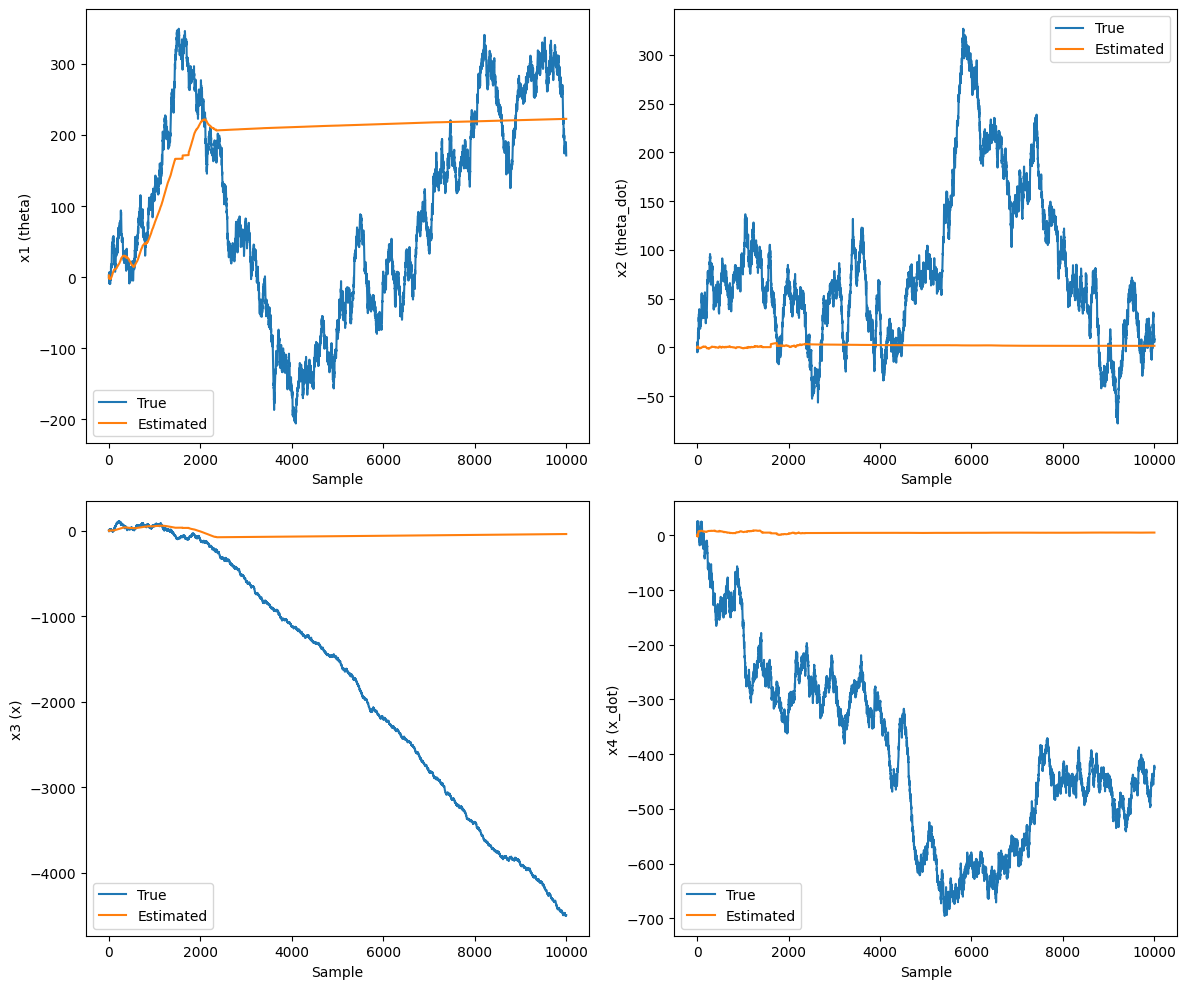

In [50]:
# ---- Plot results ----
labels= ['x1 (theta)', 'x2 (theta_dot)', 'x3 (x)', 'x4 (x_dot)']
plt.figure(figsize=(12,10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(X_true[:, i], label= 'True')
    plt.plot(X_est[:, i], label= 'Estimated')
    plt.xlabel('Sample')
    plt.ylabel(labels[i])
    plt.legend()
plt.tight_layout()
plt.show()

lets do this again